In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta
import pandas_datareader.data as web
import utils

In [39]:
# from utils.data_scraper import download_sp500_tickers 
# sp500_list = download_sp500_tickers(save_local=True)

# from utils.data_scraper import download_sp500_data

# download_sp500_data(sp500_list, save_local=True)

In [40]:
models = utils.models
data_scraper = utils.data_scraper

In [41]:
df = data_scraper.get_sp500_data()
df.dropna(inplace=True)
df = df[df.index.get_level_values('ticker') != 'SPY']
sp500_list = data_scraper.get_sp500_tickers()
sp500_list = [ticker for ticker in sp500_list if ticker != 'SPY']

c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:130: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Loaded S&P 500 historical data from 'data/sp500_data.csv'
Loaded 504 tickers from local file.


In [42]:
df

adj_close       close        high         low        open  \
date       ticker                                                               
2015-01-05 A        36.425377   39.799999   40.459999   39.700001   40.320000   
           AAPL     23.554741   26.562500   27.162500   26.352501   27.072500   
           ABBV     41.299294   64.650002   66.099998   63.880001   65.500000   
           ABT      36.426781   44.910000   45.400002   44.630001   44.799999   
           ACGL     18.428413   19.379999   19.500000   19.333332   19.393333   
...                       ...         ...         ...         ...         ...   
2025-10-30 XYZ      73.919998   73.919998   76.470001   73.714996   76.470001   
           YUM     139.059998  139.059998  140.029999  137.369995  139.050003   
           ZBH      99.559998   99.559998   99.989998   98.739998   99.169998   
           ZBRA    261.369995  261.369995  268.299988  260.450012  267.839996   
           ZTS     143.600006  144.100006  145.039993  142.440002  142.440002   

                        volume  
date       ticker               
2015-01-05 A         2041800.0  
           AAPL    257142000.0  
           ABBV      8007400.0  
           ABT       5735900.0  
           ACGL      1095900.0  
...                        ...  
2025-10-30 XYZ       6301800.0  
           YUM       2065300.0  
           ZBH       1416100.0  
           ZBRA       943700.0  
           ZTS       2476000.0  

[1323445 rows x 6 columns]

In [43]:
def safe_bbands(series, length=20):
	bb = pandas_ta.bbands(close=np.log1p(series), length=length)
	if bb is not None:
		return bb
	# Return a DataFrame of NaNs with the same index if bb is None
	return pd.DataFrame(np.nan, index=series.index, columns=['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0'])

df['garman_klass_volatility'] = ((np.log(df['high'] - np.log(df['low']) ** 2))/2 - (2 * np.log(2) - 1) * (np.log(df['adj_close']) - np.log(df['open']) ** 2))
df['rsi'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: pandas_ta.rsi(x, length=20))
df['bb_low'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,1])
df['bb_high'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,2])

c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='date'>

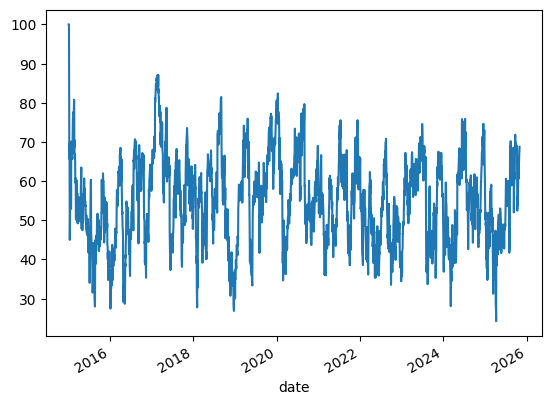

In [44]:
# All 'close' prices for ticker 'AAPL' across all dates
df.xs('AAPL', level='ticker')['rsi'].plot()

In [45]:
df.xs('A', level='ticker').head()

,adj_close,close,high,low,open,volume,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high
date,,,,,,,,,,,
2015-01-05,36.425377,39.799999,40.459999,39.700001,40.320000,2041800.0,5.536737,NaN,NaN,NaN,NaN
2015-01-06,35.857956,39.180000,40.020000,39.020000,39.810001,2080600.0,5.500655,0.000000,NaN,NaN,NaN
2015-01-07,36.333862,39.700001,39.810001,39.290001,39.520000,3359700.0,5.469849,4.227684,NaN,NaN,NaN
2015-01-08,37.422966,40.889999,40.980000,40.180000,40.240002,2116300.0,5.528581,13.079805,NaN,NaN,NaN
2015-01-09,37.148411,40.590000,41.000000,40.290001,41.000000,1644900.0,5.584968,12.766677,NaN,NaN,NaN


In [46]:
def compute_atr(stock_data: pd.DataFrame, period: int = 14) -> pd.Series:
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['adj_close'], length=period)
    return atr.sub(atr.mean()).div(atr.std())

In [47]:
df = df.dropna()
df['atr'] = df.groupby(level='ticker', group_keys=False).apply(compute_atr)

In [48]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

In [49]:
df['macd'] = df.groupby(level='ticker', group_keys=False)['adj_close'].apply(compute_macd)

In [50]:
df['dollar_volume'] = (df['volume'] * df['adj_close'])/1e6
df['close_over_open'] = np.log(df['adj_close'] / df['open'])

In [51]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = pd.concat([df.unstack(level='ticker')['dollar_volume'].resample('ME').mean().stack(level='ticker', future_stack=True).to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('ME').last().stack(level='ticker', future_stack=True)], axis=1).dropna()

In [52]:
data

dollar_volume   adj_close  garman_klass_volatility  \
date       ticker                                                       
2015-03-31 A           77.421103   38.120670                 5.605968   
           AAPL      5801.357270   27.693962                 4.809874   
           ABBV       498.025787   37.676891                 6.840715   
           ABT        197.810379   37.777473                 6.049622   
           ACGL        27.594328   19.525116                 3.633791   
...                          ...         ...                      ...   
2025-10-31 GEHC       242.242275   75.000000                 7.675149   
           KVUE       481.610112   14.062851                 2.721821   
           VLTO       145.021392  100.379997                 8.584343   
           SOLV        63.672486   69.279999                 7.302465   
           GEV       1926.315527  574.070007                16.258071   

                         rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                      
2015-03-31 A       49.679718  3.636924  3.663416  3.689908 -0.550844   
           AAPL    51.023369  3.337974  3.365978  3.393981 -0.178803   
           ABBV    46.288689  3.594490  3.651795  3.709099  0.516548   
           ABT     45.394840  3.651617  3.671048  3.690480  0.599267   
           ACGL    55.266748  2.986109  3.020091  3.054073 -1.079798   
...                      ...       ...       ...       ...       ...   
2025-10-31 GEHC    49.330688  4.274180  4.333853  4.393527  0.422078   
           KVUE    33.204788  2.686337  2.786264  2.886190 -1.398187   
           VLTO    38.786098  4.610472  4.646356  4.682239  0.138186   
           SOLV    39.357799  4.255035  4.287883  4.320732 -1.301684   
           GEV     43.636180  6.325296  6.399494  6.473693  1.651594   

                       macd  close_over_open  
date       ticker                             
2015-03-31 A      -0.049307        -0.079621  
           AAPL   -0.266508        -0.129487  
           ABBV   -0.297617        -0.431568  
           ABT    -0.137114        -0.214811  
           ACGL   -0.002140        -0.060523  
...                     ...              ...  
2025-10-31 GEHC    0.421687        -0.031240  
           KVUE   -1.739284        -0.020910  
           VLTO   -1.142906         0.008303  
           SOLV   -0.521412        -0.005614  
           GEV    -1.584256         0.007115  

[62194 rows x 10 columns]

In [53]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())
data['dollar_vol_rank'] = data.groupby(level='date')['dollar_volume'].rank(ascending=False)

In [54]:
data = data[data['dollar_vol_rank'] <= 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

**Calculate Monthly Returns for different time horizons as features**

In [55]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2020-02-29 AAPL     66.112671                 7.056595  34.635088  4.221236   
           ABBV     67.732246                 8.003115  43.432005  4.171676   
           ABT      69.579674                 7.699337  26.562324  4.281571   
           ACN     166.075134                10.974559  24.475355  5.156322   
           ADBE    345.119995                13.528691  45.805778  5.830231   
...                       ...                      ...        ...       ...   
2025-10-31 TTD      48.970001                 6.165864  42.347163  3.909562   
           MRNA     28.139999                 4.128776  55.102532  3.262788   
           UBER     96.489998                 8.432315  52.983148  4.519882   
           CRWD    538.679993                16.007218  64.030915  6.150510   
           DDOG    157.070007                10.323562  57.130258  5.017158   

                     bb_mid   bb_high       atr      macd  close_over_open  
date       ticker                                                           
2020-02-29 AAPL    4.332128  4.443020 -0.281471 -0.944593         0.027567  
           ABBV    4.282662  4.393647  0.273644 -0.154294        -0.200745  
           ABT     4.371019  4.460466  0.574250 -1.774731        -0.102890  
           ACN     5.254162  5.352003  0.345903 -1.111200        -0.081960  
           ADBE    5.901527  5.972823  0.261078 -0.060075         0.061853  
...                     ...       ...       ...       ...              ...  
2025-10-31 TTD     3.972026  4.034490 -0.034421 -0.083662        -0.011875  
           MRNA    3.329764  3.396739 -0.829109 -0.002780         0.141585  
           UBER    4.565438  4.610994  1.190897 -0.229220         0.011256  
           CRWD    6.231123  6.311737  1.494879  1.870968        -0.008190  
           DDOG    5.064711  5.112263  0.094334  0.642797         0.013266  

[10350 rows x 9 columns]

In [56]:
def calculate_monthly_returns(df: pd.DataFrame, outlier_cutoffs: float = 0.005) -> pd.DataFrame:
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj_close'].pct_change(lag)
                                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoffs), upper=x.quantile(1 - outlier_cutoffs)))
                                   .add(1)
                                   .pow(1/lag)
                                   .sub(1)
                                   )
    return df

data = data.groupby(level='ticker', group_keys=False).apply(calculate_monthly_returns).dropna()


In [57]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2021-02-28 AAPL    118.217247                 9.401131  36.515188  4.782029   
           ABBV     89.693932                 8.953130  54.185344  4.451670   
           ABT     109.876732                 9.405494  51.778718  4.695131   
           ACN     234.333237                12.466395  47.047014  5.436857   
           ADBE    459.670013                15.213833  41.726510  6.121454   
...                       ...                      ...        ...       ...   
2025-10-31 TTD      48.970001                 6.165864  42.347163  3.909562   
           MRNA     28.139999                 4.128776  55.102532  3.262788   
           UBER     96.489998                 8.432315  52.983148  4.519882   
           CRWD    538.679993                16.007218  64.030915  6.150510   
           DDOG    157.070007                10.323562  57.130258  5.017158   

                     bb_mid   bb_high       atr      macd  close_over_open  \
date       ticker                                                            
2021-02-28 AAPL    4.860659  4.939289  0.890498 -1.335623        -0.036321   
           ABBV    4.489164  4.526657  0.144019 -0.115856        -0.182761   
           ABT     4.738973  4.782814  1.585762  1.107074        -0.106218   
           ACN     5.473474  5.510092  0.755099 -0.051397        -0.085460   
           ADBE    6.180229  6.239005  0.673967 -0.478983        -0.006786   
...                     ...       ...       ...       ...              ...   
2025-10-31 TTD     3.972026  4.034490 -0.034421 -0.083662        -0.011875   
           MRNA    3.329764  3.396739 -0.829109 -0.002780         0.141585   
           UBER    4.565438  4.610994  1.190897 -0.229220         0.011256   
           CRWD    6.231123  6.311737  1.494879  1.870968        -0.008190   
           DDOG    5.064711  5.112263  0.094334  0.642797         0.013266   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2021-02-28 AAPL    -0.079712  -0.043326   0.006651  -0.009780   0.048633   
           ABBV     0.051327   0.008596   0.013895   0.024107   0.021104   
           ABT     -0.030828   0.048040   0.035796   0.016358   0.027464   
           ACN      0.037120  -0.018261   0.003557   0.008709   0.025845   
           ADBE     0.001962  -0.041293  -0.013273  -0.018253   0.019422   
...                      ...        ...        ...        ...        ...   
2025-10-31 TTD     -0.000816  -0.053479  -0.174209  -0.015036  -0.093468   
           MRNA     0.089431   0.080796  -0.016276  -0.002350  -0.037597   
           UBER    -0.015107   0.014508   0.032155   0.029573   0.041619   
           CRWD     0.098495   0.127551   0.058222   0.038726   0.034182   
           DDOG     0.103020   0.071998   0.039144   0.073967   0.010710   

                   return_12m  
date       ticker              
2021-02-28 AAPL      0.049622  
           ABBV      0.023679  
           ABT       0.038241  
           ACN       0.029108  
           ADBE      0.024172  
...                       ...  
2025-10-31 TTD      -0.070762  
           MRNA     -0.054271  
           UBER      0.024639  
           CRWD      0.050906  
           DDOG      0.018915  

[8175 rows x 15 columns]

Download Fama-French Factors and Calculate Rolling Betas

In [58]:
# utils.data_scraper.download_famafrench_data(save_local=True)

In [59]:
factor_data = data_scraper.get_famafrench_data()
factor_data

Loaded Fama-French factors from 'data/famafrench_factors.csv'


,mkt_rf,smb,hml,rmw,cma
date,,,,,
2016-01-31,-0.0574,-0.0344,0.0208,0.0278,0.0305
2016-02-29,-0.0007,0.0087,-0.0061,0.0331,0.0194
2016-03-31,0.0695,0.0100,0.0122,0.0068,0.0001
2016-04-30,0.0091,0.0123,0.0322,-0.0285,0.0177
2016-05-31,0.0178,-0.0062,-0.0162,-0.0110,-0.0254
...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208


In [60]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

mkt_rf     smb     hml     rmw     cma  return_1m
date       ticker                                                   
2021-02-28 AAPL    0.0281  0.0450  0.0720  0.0033 -0.0199  -0.079712
           ABBV    0.0281  0.0450  0.0720  0.0033 -0.0199   0.051327
           ABT     0.0281  0.0450  0.0720  0.0033 -0.0199  -0.030828
           ACN     0.0281  0.0450  0.0720  0.0033 -0.0199   0.037120
           ADBE    0.0281  0.0450  0.0720  0.0033 -0.0199   0.001962
...                   ...     ...     ...     ...     ...        ...
2025-09-30 WFC     0.0339 -0.0218 -0.0105 -0.0203 -0.0222   0.019956
           WMT     0.0339 -0.0218 -0.0105 -0.0203 -0.0222   0.062693
           XOM     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.013474
           XYZ     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.092541
           ZTS     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.064450

[8033 rows x 6 columns]

In [61]:
observations = factor_data.groupby(level='ticker').size()
valid_stocks = observations[observations >= 12]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

mkt_rf     smb     hml     rmw     cma  return_1m
date       ticker                                                   
2021-02-28 AAPL    0.0281  0.0450  0.0720  0.0033 -0.0199  -0.079712
           ABBV    0.0281  0.0450  0.0720  0.0033 -0.0199   0.051327
           ABT     0.0281  0.0450  0.0720  0.0033 -0.0199  -0.030828
           ACN     0.0281  0.0450  0.0720  0.0033 -0.0199   0.037120
           ADBE    0.0281  0.0450  0.0720  0.0033 -0.0199   0.001962
...                   ...     ...     ...     ...     ...        ...
2025-09-30 WFC     0.0339 -0.0218 -0.0105 -0.0203 -0.0222   0.019956
           WMT     0.0339 -0.0218 -0.0105 -0.0203 -0.0222   0.062693
           XOM     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.013474
           XYZ     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.092541
           ZTS     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.064450

[7976 rows x 6 columns]

In [62]:
from utils.models import calculate_betas

betas = calculate_betas(factor_data, method='rls')


In [63]:
betas

mkt_rf       smb       hml       rmw       cma
date       ticker                                                  
2021-02-28 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-09-30 WFC     0.861108 -0.136512  0.470968 -1.520548 -0.045252
           WMT     0.536291  0.053047 -0.336946  0.295511 -0.920762
           XOM     0.439935 -0.253888  0.863468  0.475679  0.383460
           XYZ     1.901151  0.494816 -0.341409 -3.527521 -0.265780
           ZTS     0.937100  0.322069  0.908105  1.701469 -0.277009

[7976 rows x 5 columns]

In [64]:
factors = ['mkt_rf', 'smb', 'hml', 'rmw', 'cma']
group_data = data.join(betas.groupby(level='ticker').shift())
group_data.loc[:, factors] = group_data.groupby(level='ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [65]:
group_data = group_data.dropna()
group_data = group_data.drop('adj_close', axis=1)

In [66]:
group_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7905 entries, (Timestamp('2021-02-28 00:00:00'), 'AAPL') to (Timestamp('2025-10-31 00:00:00'), 'TTD')
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   garman_klass_volatility  7905 non-null   float64
 1   rsi                      7905 non-null   float64
 2   bb_low                   7905 non-null   float64
 3   bb_mid                   7905 non-null   float64
 4   bb_high                  7905 non-null   float64
 5   atr                      7905 non-null   float64
 6   macd                     7905 non-null   float64
 7   close_over_open          7905 non-null   float64
 8   return_1m                7905 non-null   float64
 9   return_2m                7905 non-null   float64
 10  return_3m                7905 non-null   float64
 11  return_6m                7905 non-null   float64
 12  return_9m                7905 non-null   float64
 13  

In [67]:
# Prepare supervised target and features (assumes `data` exists)
feature_data = group_data.copy()
feature_data['target_1m'] = feature_data.groupby('ticker')['return_1m'].shift(-1)

features = [
    'rsi', 'garman_klass_volatility', 'close_over_open',
    'atr', 'macd', 'bb_low', 'bb_mid', 'bb_high',
    'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m',
    'mkt_rf', 'smb', 'hml', 'rmw', 'cma'
]


model_df = feature_data.reset_index().dropna(subset=features + ['target_1m'])



In [68]:

# Permutation test for `rolling_train_predict_windowed`
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from utils.models import rolling_train_predict_windowed

def permutation_test_rolling(model_df, features, n_permutations=5, random_state=0, tune_model=True, top_k=15, window_months=12, min_train_rows=150):
    
    rng = np.random.RandomState(random_state)

    # Baseline run
    print("Running baseline (this may take a while)...")
    baseline_fixed_raw, diag, last_model, last_scaler = rolling_train_predict_windowed(
        model_df, features, top_k=top_k,
        window_months=window_months, min_train_rows=min_train_rows,
        tune_model=True
    )

    # ✅ TRANSFORM IMMEDIATELY (just like supervised notebook)
    baseline_fixed = {}
    for d, tickers in baseline_fixed_raw.items():
        new_date = (pd.to_datetime(d) + pd.DateOffset(days=1)).replace(day=1)
        baseline_fixed[new_date.strftime('%Y-%m-%d')] = tickers

    if diag.empty:
        print("Baseline produced no diagnostics (insufficient history). Aborting.")
        return None

    baseline_metric = diag['realized_mean'].mean()
    print(f'Baseline realized_mean mean = {baseline_metric:.6f}')

    perm_metrics = []
    perm_fixed = []
    
    for i in tqdm(range(n_permutations), desc='Permutations'):
        perm_df = model_df.copy()
        permuted = perm_df['target_1m'].values.copy()
        rng.shuffle(permuted)
        perm_df['target_1m'] = permuted

        fixed_dates_pred_raw, preds_df, last_model, scaler = rolling_train_predict_windowed(
            perm_df, features,
            top_k=15, model_type='randomforest', tune_model=True,
            window_months=12, min_train_rows=150
        )

        # ✅ TRANSFORM IMMEDIATELY for each permutation too
        fixed_dates_pred = {}
        for d, tickers in fixed_dates_pred_raw.items():
            new_date = (pd.to_datetime(d) + pd.DateOffset(days=1)).replace(day=1)
            fixed_dates_pred[new_date.strftime('%Y-%m-%d')] = tickers

        # Sort and store
        fixed_dates_pred = dict(sorted(fixed_dates_pred.items(), key=lambda x: pd.to_datetime(x[0])))
        perm_fixed.append(fixed_dates_pred)

        if preds_df.empty:
            perm_metrics.append(np.nan)
        else:
            perm_metrics.append(preds_df['realized_mean'].mean())

    perm_metrics = np.array(perm_metrics, dtype=float)
    valid_mask = ~np.isnan(perm_metrics)
    perm_metrics_valid = perm_metrics[valid_mask]
    perm_fixed_valid = [pf for pf, ok in zip(perm_fixed, valid_mask) if ok]

    if perm_metrics_valid.size == 0:
        print("No valid permutation diagnostics were produced.")
        return {
            'baseline': baseline_metric,
            'perm_metrics': perm_metrics,
            'p_value': np.nan,
            'baseline_fixed': baseline_fixed,
            'perm_fixed': perm_fixed,
        }

    # p-values: compute both directions and two-sided
    p_value_gte = (perm_metrics_valid >= baseline_metric).mean()  # prob perm >= baseline
    p_value_lte = (perm_metrics_valid <= baseline_metric).mean()  # prob perm <= baseline
    p_value_two_sided = 2 * min(p_value_gte, p_value_lte)
    p_value_two_sided = min(p_value_two_sided, 1.0)

    # effect size and median of permutation null
    median_perm = float(np.median(perm_metrics_valid))
    effect_size = float(baseline_metric - median_perm)

    # Plot the permutation distribution
    plt.figure(figsize=(8,4))
    plt.hist(perm_metrics_valid, bins=30, alpha=0.8)
    plt.axvline(baseline_metric, color='red', linewidth=2, label=f'baseline={baseline_metric:.6f}')
    plt.axvline(median_perm, color='black', linestyle='--', linewidth=1, label=f'perm_median={median_perm:.6f}')
    plt.xlabel('Mean realized_mean (selected tickers)')
    plt.legend()
    plt.title('Permutation distribution (realized_mean)')
    plt.show()

    print(f'Permutation p-value (>= baseline): {p_value_gte:.4f}; (<= baseline): {p_value_lte:.4f}; two-sided: {p_value_two_sided:.4f} (n={len(perm_metrics_valid)})')
    print(f'Baseline - perm_median = effect_size: {effect_size:.6f}')

    return {
        'baseline': baseline_metric,
        'perm_metrics': perm_metrics,
        'perm_metrics_valid': perm_metrics_valid,
        'n_valid_permutations': int(len(perm_metrics_valid)),
        'p_value_gte': float(p_value_gte),
        'p_value_lte': float(p_value_lte),
        'p_value_two_sided': float(p_value_two_sided),
        'median_perm': median_perm,
        'effect_size': effect_size,
        'baseline_fixed': baseline_fixed,
        'perm_fixed': perm_fixed,
    }


Running baseline (this may take a while)...
Baseline realized_mean mean = 0.014513


Permutations:   0%|          | 0/10 [00:00<?, ?it/s]

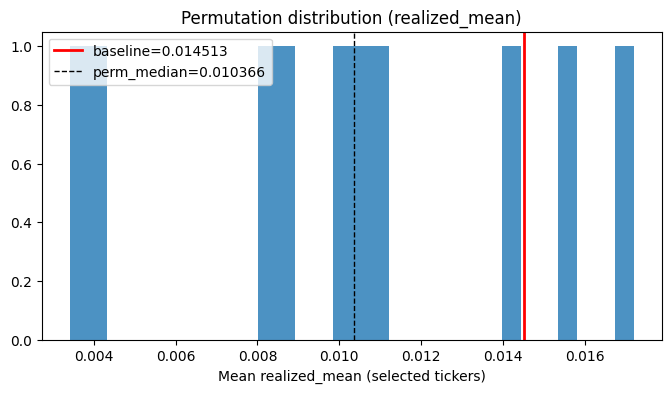

Permutation p-value (>= baseline): 0.2000; (<= baseline): 0.8000; two-sided: 0.4000 (n=10)
Baseline - perm_median = effect_size: 0.004147


In [69]:
import os
N_PERMS = 10
RANDOM_SEED = 42
TOP_K = 15
WINDOW_MONTHS = 12
MIN_TRAIN_ROWS = 150
OUT_DIR = "data"
os.makedirs(OUT_DIR, exist_ok=True)

# Run permutation test (assumes permutation_test_rolling is in scope)
perm_res = permutation_test_rolling(
    model_df=model_df,
    features=features,
    n_permutations=N_PERMS,
    random_state=RANDOM_SEED,
    tune_model=True,        # recommended: faster & consistent null
    top_k=TOP_K,
    window_months=WINDOW_MONTHS,
    min_train_rows=MIN_TRAIN_ROWS,
)

In [70]:
stocks = feature_data.index.get_level_values('ticker').unique().tolist()

new_df = data_scraper.get_sp500_data(tickers=stocks,
                                     start_date=feature_data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                                     end_date=feature_data.index.get_level_values('date').unique()[-1])
new_df = new_df.adj_close.unstack('ticker')

new_df

c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:130: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Loaded S&P 500 historical data from 'data/sp500_data.csv'
Filtering data between 2020-02-28 00:00:00 and 2025-10-31 00:00:00
Filtering data for specified tickers


ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AMAT,AMD,...,V,VLO,VRTX,VZ,WDAY,WFC,WMT,WYNN,XOM,XYZ
date,,,,,,,,,,,,,,,,,,,,,
2020-02-28,66.112671,67.732246,69.579674,166.075134,345.119995,98.790718,137.053436,190.880005,55.090530,45.480000,...,174.467102,52.471718,224.029999,38.857361,173.250000,35.373253,33.051899,104.955338,39.492058,83.330002
2020-03-02,72.267799,70.087196,73.716690,174.315018,360.279999,100.801849,144.369293,190.830002,57.024216,47.459999,...,184.613007,53.754807,232.289993,41.124523,172.889999,36.594215,35.568844,104.916458,41.365326,80.669998
2020-03-03,69.972610,69.202103,70.446808,167.574127,348.339996,97.114738,137.496292,180.550003,55.014717,46.750000,...,178.277832,51.038155,228.259995,39.962242,166.559998,35.096153,34.657223,99.570526,39.384590,78.839996
2020-03-04,73.218285,72.505348,74.150246,173.680496,363.850006,101.879868,145.600464,191.419998,57.365440,50.110001,...,186.494324,50.808464,245.320007,41.698483,170.889999,35.849510,35.842037,102.700325,40.244438,79.260002
2020-03-05,70.843300,71.604469,72.732117,167.886841,351.029999,98.627647,142.305679,184.039993,56.047894,48.110001,...,179.458496,48.868000,237.309998,41.009727,165.309998,33.684681,35.581127,92.902687,38.470989,76.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-24,262.565491,227.990005,126.849998,247.649994,353.519989,238.009995,280.940002,312.880005,228.302490,252.919998,...,346.693298,169.978149,421.390015,38.820000,242.750000,85.958069,106.169998,125.309982,114.389481,79.540001
2025-10-27,268.549652,228.029999,127.180000,250.770004,357.799988,243.009995,280.529999,313.529999,230.877441,259.670013,...,347.132416,173.257477,420.170013,39.230000,238.910004,86.554932,104.470001,125.180252,114.934715,80.150002
2025-10-28,268.739471,227.539993,126.610001,253.350006,359.910004,239.350006,279.630005,311.079987,227.194656,258.010010,...,346.214233,168.278854,422.390015,39.320000,236.929993,86.445503,103.169998,120.599754,114.032600,80.180000


In [71]:
perm_res

{'baseline': np.float64(0.014512998898047871),
 'perm_metrics': array([0.01443123, 0.017199  , 0.00839174, 0.01101712, 0.00341264,
        0.01557187, 0.01049159, 0.00860991, 0.00409885, 0.01023945]),
 'perm_metrics_valid': array([0.01443123, 0.017199  , 0.00839174, 0.01101712, 0.00341264,
        0.01557187, 0.01049159, 0.00860991, 0.00409885, 0.01023945]),
 'n_valid_permutations': 10,
 'p_value_gte': 0.2,
 'p_value_lte': 0.8,
 'p_value_two_sided': 0.4,
 'median_perm': 0.010365518179316194,
 'effect_size': 0.004147480718731677,
 'baseline_fixed': {'2021-05-01': ['QCOM',
   'TSLA',
   'DD',
   'AMGN',
   'GILD',
   'TMO',
   'REGN',
   'MO',
   'NEE',
   'VRTX',
   'VZ',
   'CVS',
   'MMM',
   'COST',
   'NKE'],
  '2021-06-01': ['T',
   'MO',
   'VZ',
   'DE',
   'MU',
   'SLB',
   'CVX',
   'USB',
   'F',
   'EOG',
   'AMGN',
   'COP',
   'MAR',
   'XOM',
   'CAT'],
  '2021-07-01': ['VZ',
   'T',
   'MO',
   'AMGN',
   'BKNG',
   'INTC',
   'LUV',
   'LMT',
   'EOG',
   'LVS',
   'CVX

In [72]:
from utils.portfolio import optimise_weights

In [73]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Optional

def compute_portfolio_returns_from_fixed(
    fixed_dates: Dict[str, List[str]],
    price_df: pd.DataFrame,
) -> pd.DataFrame:
    """Given `fixed_dates` (rebalance date -> tickers) and `price_df` (prices),
    compute a daily timeseries of strategy simple returns based on optimised
    weights for each rebalance period.
    
    EXACTLY MATCHES THE LOGIC FROM testing_supervised.ipynb

    Parameters
    - fixed_dates: mapping 'YYYY-MM-DD' -> list of tickers
    - price_df: DataFrame indexed by date, columns=tickers (prices)

    Returns DataFrame with column 'strategy_return' indexed by date.
    """
    returns_dataframe = price_df.pct_change().dropna().copy()

    portfolio_df = pd.DataFrame()

    for start_date in fixed_dates.keys():
        
        try:
        
            end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
            
            cols = fixed_dates[start_date]
            
            optimisation_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
            
            optimisation_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
            
            optimisation_df = price_df.loc[optimisation_start_date:optimisation_end_date].copy()
            optimisation_df = optimisation_df[cols]

            success = False
            
            try:
                
                weights = optimise_weights(prices=optimisation_df,
                                    lower_bound=round(1/len(optimisation_df.columns)*0.5, 3))
                
                weights = pd.DataFrame(weights, index=pd.Series(0))
                
                success = True
            except Exception as e:
                weights = pd.DataFrame()
                print(f"Maximium Sharpe Ratio optimization failed for start date {start_date}: {e} continuing with equal weights for all tickers")
            
            
            if success == False:
                weights = pd.DataFrame([1/len(optimisation_df.columns) for i in range(len(optimisation_df.columns))],
                                    index=optimisation_df.columns.tolist(),
                                    columns=pd.Series(0)).T
                
            temp_df = returns_dataframe[start_date:end_date]
            
            temp_df = temp_df.stack(future_stack=True).to_frame('return').reset_index(level=0) \
                .merge(weights.stack(future_stack=True).to_frame('weight').reset_index(level=0, drop=True),
                    left_index=True,
                    right_index=True) \
                .reset_index().set_index(['date', 'ticker']).unstack().stack(future_stack=True)

            temp_df.index.names = ['date' , 'ticker']
            
            temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
            
            temp_df = temp_df.groupby(level='date')['weighted_return'].sum().to_frame('strategy_return')
            
            portfolio_df = pd.concat([portfolio_df, temp_df])
        except Exception as e:
            print(f"An error occurred for start date {start_date}: {e}")
    print(portfolio_df)
    return portfolio_df

Processing 10 valid permutations...
            strategy_return
date                       
2021-05-03         0.010648
2021-05-04        -0.001335
2021-05-05         0.002559
2021-05-06         0.006674
2021-05-07         0.007375
...                     ...
2025-10-24         0.012027
2025-10-27         0.017388
2025-10-28         0.001082
2025-10-29        -0.000130
2025-10-30        -0.003107

[1131 rows x 1 columns]
            strategy_return
date                       
2021-05-03         0.004937
2021-05-04         0.005367
2021-05-05         0.015541
2021-05-06         0.008712
2021-05-07         0.011935
...                     ...
2025-10-24        -0.003745
2025-10-27        -0.001549
2025-10-28         0.007326
2025-10-29         0.002401
2025-10-30        -0.004898

[1131 rows x 1 columns]
            strategy_return
date                       
2021-05-03         0.018205
2021-05-04         0.004684
2021-05-05         0.029770
2021-05-06         0.005478
2021-05-07        

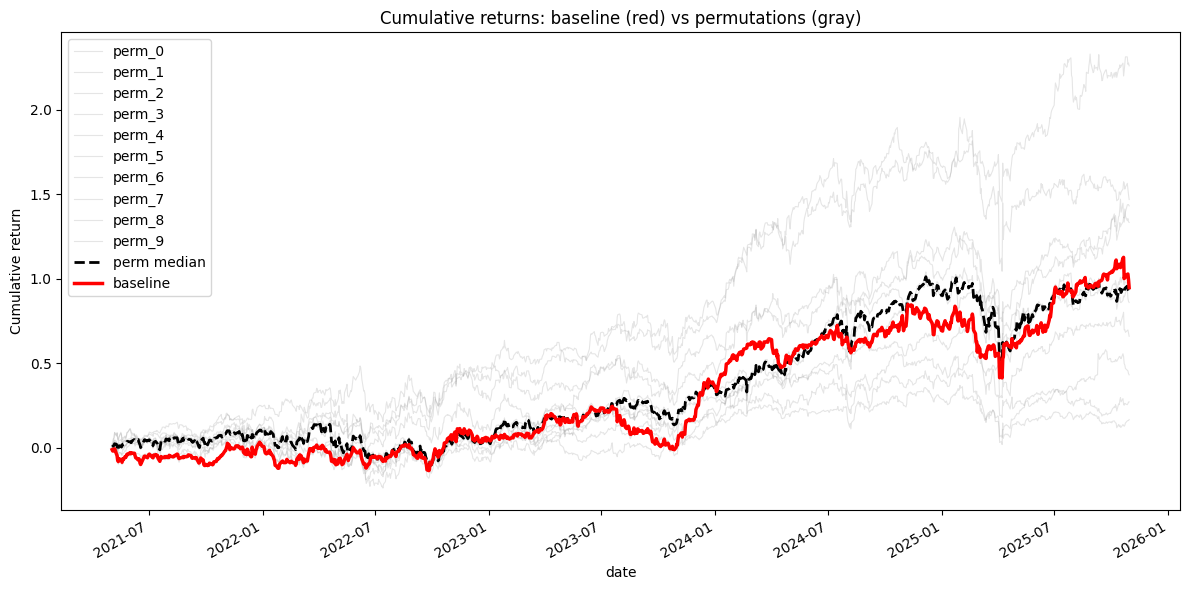


Saved per-permutation CSVs to: data/permutations
Valid permutations used: 10
Baseline final return: 0.9474
Permutation median final return: 0.9216
Difference: 0.0258


In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "data/permutations"
os.makedirs(OUT_DIR, exist_ok=True)

# Apply transformation
baseline_fixed_transformed = perm_res["baseline_fixed"]
perm_fixed_all_transformed = perm_res["perm_fixed"]

perm_metrics = np.asarray(perm_res["perm_metrics"])
valid_mask = ~np.isnan(perm_metrics)

# Containers (keep original permutation index)
perm_cum_series = {}    # original_perm_index -> cumulative Series
perm_pf_by_index = {}   # original_perm_index -> per-day simple returns DF

print(f"Processing {valid_mask.sum()} valid permutations...")

for idx, fixed_map in enumerate(perm_fixed_all_transformed):
    # skip if mapping empty or permutation had invalid diagnostic
    pf = compute_portfolio_returns_from_fixed(fixed_map, new_df)
    if pf.empty:
        print(f"Warning: permutation {idx} returned empty portfolio")
        continue

    cum = (1 + pf["strategy_return"]).cumprod() - 1
    cum.name = f"perm_{idx}"
    perm_cum_series[idx] = cum
    perm_pf_by_index[idx] = pf

    # optional: save this permutation's cumulative series
    cum.to_csv(os.path.join(OUT_DIR, f"perm_{idx}_cumulative.csv"))


# Aggregate into a DataFrame aligned on dates (columns named by original perm index)
if perm_cum_series:
    perm_df_cum = pd.concat([s.rename(f"perm_{i}") for i, s in perm_cum_series.items()], axis=1).sort_index()
    perm_df_cum.to_csv(os.path.join(OUT_DIR, "perm_cumulative_all.csv"))
    print(f"Saved {len(perm_cum_series)} permutation series to CSV")
else:
    perm_df_cum = pd.DataFrame()
    print("Warning: No valid permutation series generated")

# Baseline
print("\nProcessing baseline...")
try:
    baseline_pf = compute_portfolio_returns_from_fixed(baseline_fixed_transformed, new_df)
    baseline_cum = (1 + baseline_pf["strategy_return"]).cumprod() - 1 if not baseline_pf.empty else pd.Series(dtype=float)
    baseline_cum.to_csv(os.path.join(OUT_DIR, "baseline_cumulative.csv"))
    print(f"Baseline final cumulative return: {baseline_cum.iloc[-1]:.4f}" if not baseline_cum.empty else "Baseline is empty")
except Exception as e:
    print(f"Error processing baseline: {e}")
    baseline_cum = pd.Series(dtype=float)

# Quick aggregated plot (if you want to visualise here)
fig, ax = plt.subplots(figsize=(12,6))
if not perm_df_cum.empty:
    # Plot each permutation softly
    for col in perm_df_cum.columns:
        perm_df_cum[col].plot(ax=ax, color="gray", alpha=0.2, linewidth=0.8, label=None)
    
    # Calculate and plot median with thicker line
    median = perm_df_cum.median(axis=1)
    median.plot(ax=ax, color="black", linestyle="--", linewidth=2, label="perm median")

if not baseline_cum.empty:
    baseline_cum.plot(ax=ax, color="red", linewidth=2.5, label="baseline")

ax.set_title("Cumulative returns: baseline (red) vs permutations (gray)")
ax.set_ylabel("Cumulative return")
ax.legend()
plt.tight_layout()
plt.show()

# Summary
print(f"\n{'='*60}")
print(f"Saved per-permutation CSVs to: {OUT_DIR}")
print(f"Valid permutations used: {len(perm_cum_series)}")
if not baseline_cum.empty and not perm_df_cum.empty:
    perm_median_final = perm_df_cum.iloc[-1].median()
    baseline_final = baseline_cum.iloc[-1]
    print(f"Baseline final return: {baseline_final:.4f}")
    print(f"Permutation median final return: {perm_median_final:.4f}")
    print(f"Difference: {baseline_final - perm_median_final:.4f}")
print(f"{'='*60}")